In [1]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
import numpy as np

import matplotlib.pyplot as plt

In [2]:
X,y = fetch_openml(data_id=43843,return_X_y=True,as_frame=True)

c:\Users\Jason\Desktop\git_control\ml-research\.venv\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X.index = pd.to_datetime(X['LOCAL_DATE']).values

In [4]:
X['MEAN_TEMPERATURE_TORONTO']

1940-01-01    -8.9
1940-01-02   -13.1
1940-01-03    -6.1
1940-01-04    -6.4
1940-01-05    -7.2
              ... 
2019-12-28     3.0
2019-12-29     1.1
2019-12-30     5.6
2019-12-31     0.4
2020-01-01    -1.7
Name: MEAN_TEMPERATURE_TORONTO, Length: 29221, dtype: float64

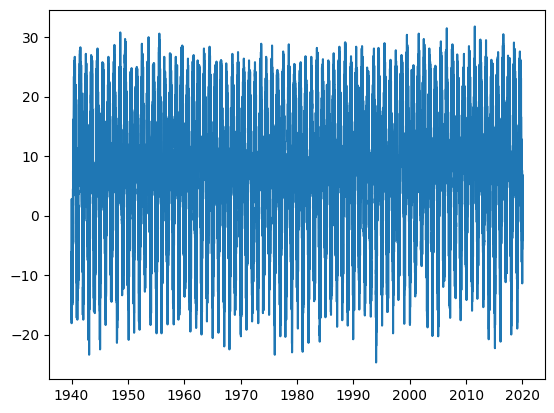

In [5]:
plt.plot(X['MEAN_TEMPERATURE_TORONTO'])

In [6]:
X['TOR_86']=np.where(X['MEAN_TEMPERATURE_TORONTO']>30,1,0)

In [7]:
sum(X['TOR_86'])

7

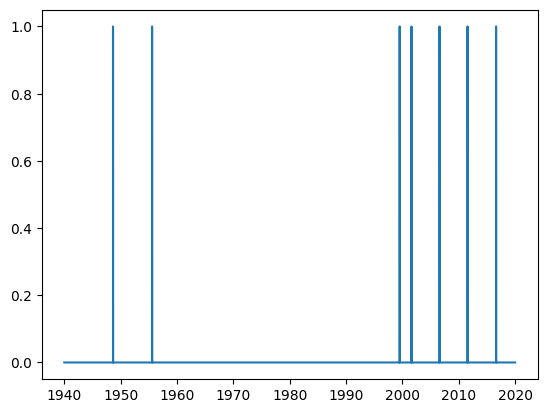

In [8]:
plt.plot(X['TOR_86'])

In [9]:
X['DAY']=range(1,len(X)+1)
X['LOG_DAY'] =np.log( X['DAY'])
X['month'] = pd.to_datetime(X['LOCAL_DATE']).dt.month
for m in range(1,13):
    X[f'MONTH_{m}']=np.where(X['month']==m,1,0)
X['NEXT_90'] = X['TOR_86'].rolling(window=90,min_periods=90).max().fillna(0)

In [11]:
X

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,NEXT_90
1940-01-01,01-Jan-1940 00:00:00,-11.4,0.5,None,None,None,None,-8.9,0.0,None,...,0,0,0,0,0,0,0,0,0,0.0
1940-01-02,02-Jan-1940 00:00:00,-12.0,0.5,None,None,None,None,-14.5,0.0,None,...,0,0,0,0,0,0,0,0,0,0.0
1940-01-03,03-Jan-1940 00:00:00,-12.0,1.0,None,None,None,None,-11.1,0.0,None,...,0,0,0,0,0,0,0,0,0,0.0
1940-01-04,04-Jan-1940 00:00:00,-11.4,0.8,None,None,None,None,-11.1,0.3,None,...,0,0,0,0,0,0,0,0,0,0.0
1940-01-05,05-Jan-1940 00:00:00,-13.1,0.5,None,None,None,None,-8.1,0.0,None,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,28-Dec-2019 00:00:00,-7.7,0.0,-10.4,0.0,2.1,0.0,0.5,NaN,1.3,...,0,0,0,0,0,0,0,0,1,0.0
2019-12-29,29-Dec-2019 00:00:00,-3.3,0.0,-8.6,0.0,-2.7,0.0,-3.8,NaN,-0.9,...,0,0,0,0,0,0,0,0,1,0.0
2019-12-30,30-Dec-2019 00:00:00,-1.6,0.0,-10.3,0.0,-3.5,0.0,-4.1,NaN,-2.3,...,0,0,0,0,0,0,0,0,1,0.0
2019-12-31,31-Dec-2019 00:00:00,4.3,0.0,-2.6,0.0,0.0,11.4,-1.0,NaN,-0.2,...,0,0,0,0,0,0,0,0,1,0.0


In [13]:
features = ['DAY']+[i for i in X.columns if ('MONTH_' in i)&(i not in 'MONTH_4')]
target = 'NEXT_90'



In [14]:
pipe = Pipeline(steps=[
    ('scaler',MinMaxScaler()),
    ('learner',PoissonRegressor(alpha=0,max_iter=10000))
])
X_train = X[features].copy()
y_train = X[target].copy()

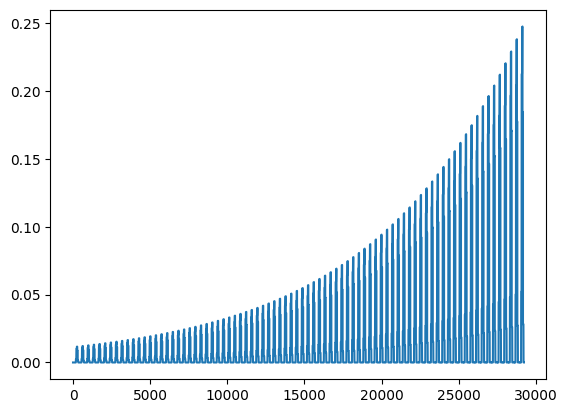

In [15]:
pipe.fit(X_train,y_train,learner__sample_weight=X['DAY'])
pred = pipe.predict(X_train)
max(pred)
plt.plot(pred)

In [16]:
X_train_pos = X_train[y_train==1].copy()
Y_train_pos = y_train[y_train==1].copy()
weight_train_pos = X[y_train==1]['DAY'].copy()
X_train_neg = X_train[y_train==0].copy()
Y_train_neg = y_train[y_train==0].copy()
weight_train_neg = X[y_train==0]['DAY'].copy()


In [17]:
X_train_pos_samp,y_train_pos_samp,weight_train_pos_samp = resample(X_train_pos,Y_train_pos,weight_train_pos,
                                             n_samples=1000,replace=True,random_state=0)
X_train_neg_samp,y_train_neg_samp,weight_train_neg_samp = resample(X_train_neg,Y_train_neg,weight_train_neg,
                                             n_samples=10000,replace=True,random_state=0)

In [18]:
X_train_samp = pd.concat([X_train_pos_samp,X_train_neg_samp])
y_train_samp = pd.concat([y_train_pos_samp,y_train_neg_samp])
weight_train_samp = pd.concat([weight_train_pos_samp,weight_train_neg_samp])


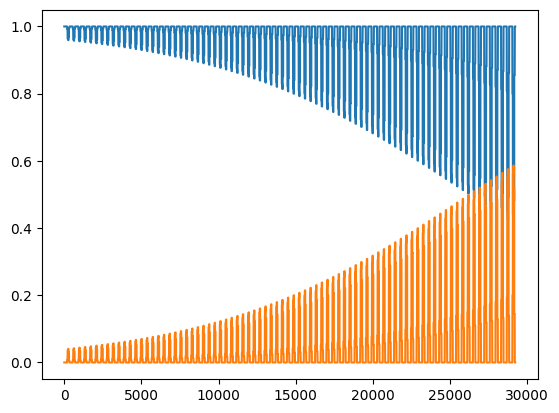

In [19]:
pipe = Pipeline(steps=[
    ('scaler',MinMaxScaler()),
    ('learner',LogisticRegression(class_weight={1:1,0:1}))
]).fit(X_train_samp,y_train_samp,learner__sample_weight=weight_train_samp)
pred=pipe.predict_proba(X_train)
plt.plot(pred)

In [ ]:
pred

In [ ]:
plt.plot(X['TOR_86'].rolling(window=90,min_periods=90).max().fillna(0))

In [ ]:
X['TOR_86'].rolling(window=30)